In [4]:
import pickle
import pandas as pd
import sys
sys.path.insert(0, "/home/gh464/Documents/GitHub/SyMBac/") 
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from SyMBac.renderer import convolve_rescale
from tqdm.auto import tqdm
from skimage import color, data, restoration
from matplotlib.colors import LogNorm

In [5]:
import numpy as np

def center_of_mass_3d(array):
    # Generate a grid of indices
    z_indices, y_indices, x_indices = np.indices(array.shape)

    # Compute the total mass
    total_mass = array.sum()

    # Calculate the weighted sum of indices
    x_center = (x_indices * array).sum() / total_mass
    y_center = (y_indices * array).sum() / total_mass
    z_center = (z_indices * array).sum() / total_mass

    return z_center, y_center, x_center

In [6]:
pix_mic_conv = 0.01
resize_amount = 1
real_PSF = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag.tif")
z_center = center_of_mass_3d(real_PSF)[0]
real_PSF = real_PSF[44-int(0.5/(0.05)):44+int(0.5/(0.05))]
real_PSF = rescale(real_PSF, (0.05/pix_mic_conv, (0.0655/1.5) / pix_mic_conv, (0.0655/1.5) / pix_mic_conv)  , anti_aliasing=True)
real_PSF -= real_PSF.min()
real_PSF = real_PSF / np.sum(real_PSF)


In [7]:
post_conv_layer_scaling = real_PSF.sum(axis=(1,2))


In [8]:
real_PSF_rescaled = []
for i in real_PSF:
    j = i - i.min()
    j = i / i.sum()
    real_PSF_rescaled.append(j)
real_PSF_rescaled = np.array(real_PSF_rescaled)
#a *= real_PSF.sum(axis=(1,2))


In [9]:
real_PSF_flat = real_PSF.sum(axis = 0)
real_PSF_flat -= real_PSF_flat.min()
real_PSF_flat /= real_PSF_flat.sum()


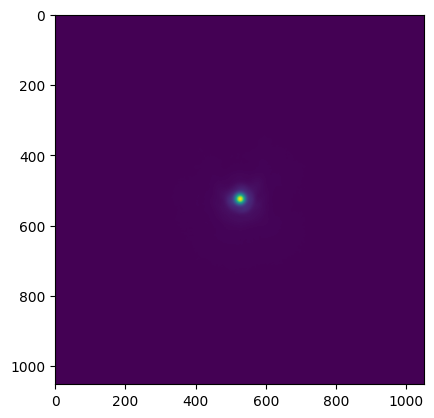

In [10]:
plt.imshow(real_PSF_flat)

In [11]:
cell_length = 3 #micron
cell_width = 1 #micron
raster_cell_length = cell_length / pix_mic_conv
raster_cell_width = cell_width / pix_mic_conv
def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount = False):


    membrane_thickness = 0.1 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, separation=0)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, separation=0)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

In [12]:
membrane_cell = np.pad(raster_membrane_cell_3d(raster_cell_length,raster_cell_width), ((1,1),(500,500),(500,500)))
print(membrane_cell.shape)

(100, 1300, 1100)


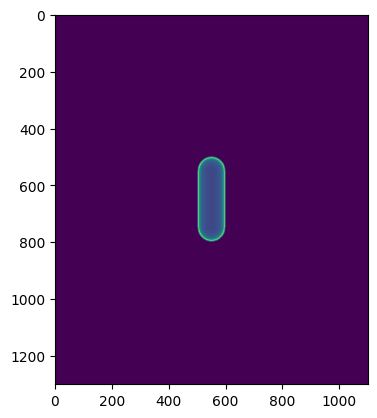

In [13]:
plt.imshow(membrane_cell.sum(axis=0))

In [14]:
membrane_cell.sum()

428312

In [15]:
conv_2d = convolve_rescale(membrane_cell.sum(axis=0).astype(float), real_PSF_flat, 1, False)

In [16]:
conv_2d.sum()

427209.79863242386

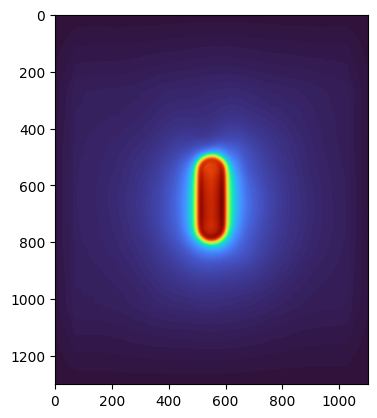

In [17]:
plt.imshow(conv_2d, cmap="turbo")

In [18]:
conv_2d.max()

5.789829384012592

In [19]:
real_PSF[0].sum()

0.010939787

In [20]:
conv_3d = np.array([convolve_rescale(membrane_cell_layer.astype(float), real_PSF_layer, 1, False) for membrane_cell_layer, real_PSF_layer in zip(tqdm(membrane_cell), real_PSF_rescaled)])
conv_3d_2d = conv_3d.sum(axis=0)
conv_3d_2d = conv_3d_2d * membrane_cell.sum() / conv_3d_2d.sum() 

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
conv_3d_2d.max()

In [ ]:
post_conv_layer_scaling = real_PSF.sum(axis=(1,2))
conv_3d_post_conv_rescale = np.array([x*y for x, y in zip(conv_3d, post_conv_layer_scaling)])
conv_3d_post_conv_rescale_2d = conv_3d_post_conv_rescale.sum(axis=0)
conv_3d_post_conv_rescale_2d.sum()

In [ ]:
post_conv_layer_scaling.sum()

In [ ]:
plt.imshow(conv_3d_post_conv_rescale_2d, cmap="Greys_r")

In [ ]:
conv_3d_post_conv_rescale_2d *= membrane_cell.sum() / conv_3d_post_conv_rescale_2d.sum() 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming conv_2d and conv_3d_2d are your images

# Calculate percentage difference
percentage_diff = np.abs(100 *  (conv_2d/conv_2d.max() - (conv_3d_post_conv_rescale_2d/conv_3d_post_conv_rescale_2d.max()) )/ (conv_3d_post_conv_rescale_2d/conv_3d_post_conv_rescale_2d.max()))

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot conv_2d
ax1 = axes[0]
cax1 = ax1.imshow(conv_2d, cmap='Greys_r')
fig.colorbar(cax1, ax=ax1)
ax1.set_title('2D Convolution')

# Plot conv_3d_2d
ax2 = axes[1]
cax2 = ax2.imshow(conv_3d_post_conv_rescale_2d, cmap='Greys_r')
fig.colorbar(cax2, ax=ax2)
ax2.set_title('3D Convolution (2D projection)')

# Plot percentage difference
ax3 = axes[2]
cax3 = ax3.imshow(percentage_diff, cmap='Greys_r', norm = LogNorm())
fig.colorbar(cax3, ax=ax3)
ax3.set_title('Absolute Percentage Difference')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
def raster_cell_3d(raster_cell_length, raster_cell_width):

    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, separation=0)

    cell_1_3d = convert_to_3D(cell_1)
    
    cell_3d = cell_1_3d 
    
    
    return cell_3d

In [ ]:
normal_cell = np.pad(raster_cell_3d(raster_cell_length,raster_cell_width), ((1,1),(500,500),(500,500)))
print(normal_cell.shape)

In [ ]:
plt.imshow(normal_cell.sum(axis=0))

In [ ]:
conv_2d_normal = convolve_rescale(normal_cell.sum(axis=0).astype(float), real_PSF_flat, 1, False)

In [ ]:
conv_2d_normal.sum()

In [ ]:
plt.imshow(conv_2d_normal, cmap="turbo")

In [ ]:
conv_2d_normal.max()

In [ ]:
conv_3d_normal = np.array([convolve_rescale(cell_layer.astype(float), real_PSF_layer, 1, False) for cell_layer, real_PSF_layer in zip(tqdm(normal_cell), real_PSF_rescaled)])
conv_3d_2d_normal = conv_3d_normal.sum(axis=0)
conv_3d_2d_normal = conv_3d_2d_normal * normal_cell.sum() / conv_3d_2d_normal.sum() 

In [ ]:
conv_3d_2d_normal.max()

In [ ]:
post_conv_layer_scaling = real_PSF.sum(axis=(1,2))
conv_3d_post_conv_rescale_normal = np.array([x*y for x, y in zip(conv_3d_normal, post_conv_layer_scaling)])
conv_3d_post_conv_rescale_2d_normal = conv_3d_post_conv_rescale_normal.sum(axis=0)
conv_3d_post_conv_rescale_2d_normal.sum()

In [ ]:
plt.imshow(conv_3d_post_conv_rescale_2d_normal, cmap="Greys_r")

In [ ]:
conv_3d_post_conv_rescale_2d_normal *= normal_cell.sum() / conv_3d_post_conv_rescale_2d_normal.sum() 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming conv_2d and conv_3d_2d are your images

# Calculate percentage difference
percentage_diff_normal = np.abs(100 * (conv_2d_normal/conv_2d_normal.max() - (conv_3d_post_conv_rescale_2d_normal/conv_3d_post_conv_rescale_2d_normal.max())) / (conv_3d_post_conv_rescale_2d_normal/conv_3d_post_conv_rescale_2d_normal.max()))

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot conv_2d
ax1 = axes[0]
cax1 = ax1.imshow(conv_2d_normal, cmap='Greys_r')
fig.colorbar(cax1, ax=ax1)
ax1.set_title('2D Convolution')

# Plot conv_3d_2d
ax2 = axes[1]
cax2 = ax2.imshow(conv_3d_post_conv_rescale_2d_normal, cmap='Greys_r')
fig.colorbar(cax2, ax=ax2)
ax2.set_title('3D Convolution (2D projection)')

# Plot percentage difference
ax3 = axes[2]
cax3 = ax3.imshow(percentage_diff_normal, cmap='Greys_r', norm = LogNorm())
fig.colorbar(cax3, ax=ax3)
ax3.set_title('Absolute Percentage Difference')

# Show the plot
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
import seaborn as sns
import matplotlib

In [28]:
matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
plt.rcParams['figure.titlesize'] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
matplotlib.rcParams["axes.titlesize"] = 6

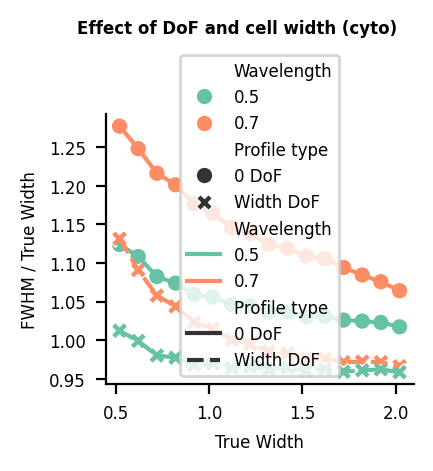

In [44]:

melted_data = pd.read_pickle("../../single_cell_projection_diffraction/membrane_targeted_simulation_data_cyto.pickle")
fig, ax = plt.subplots(1,1, figsize=(2.2,2.2), dpi = 200)
sns.scatterplot(melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1"), x = "True Width", y = "Observed Width / True Width", hue = "Wavelength", style="Profile type", palette="Set2")
sns.lineplot(melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1"), x = "True Width", y = "Observed Width / True Width", hue = "Wavelength", style="Profile type", palette="Set2")
plt.subplots_adjust(left=0.2, top = 0.765, bottom=0.15, right = 0.9)
plt.ylabel("FWHM / True Width")
plt.suptitle("Effect of DoF and cell width (cyto)", fontsize=6, weight = "bold")
plt.savefig("3a.svg")

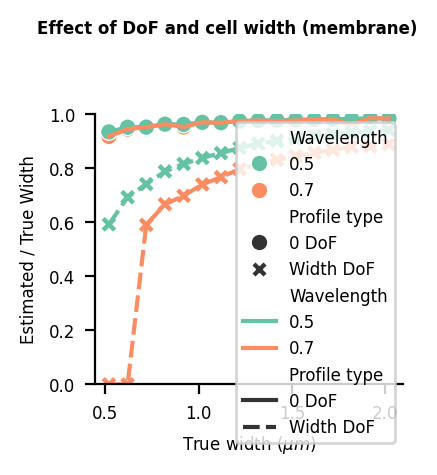

In [43]:
melted_data = pd.read_pickle("../../single_cell_projection_diffraction/membrane_targeted_simulation_data.pickle")
fig, ax = plt.subplots(1,1, figsize=(2.2,2.2), dpi = 200)
sns.scatterplot(data = melted_data.query("`PSF Type` == 'ePSF' & `True Width` <= 2.1"), x = "True Width", y = "Observed Width / True Width", hue = "Wavelength", style="Profile type", palette="Set2")

sns.lineplot(data=melted_data.query("`PSF Type` == 'ePSF' & `True Width` <= 2.1"), 
             x="True Width", 
             y="Observed Width / True Width", 
             hue="Wavelength", 
             style="Profile type", 
             palette="Set2", 
             ax=ax)  # Ensure the line plot is on the same axes


plt.subplots_adjust(left=0.2, top = 0.765, bottom=0.15, right = 0.9)
plt.xlabel("True width ($\mu m$)")
plt.ylabel("Estimated / True Width")
plt.suptitle("Effect of DoF and cell width (membrane)", fontsize = 6, weight = "bold")
plt.ylim(0,1)
plt.savefig("3b.svg")